In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
DEVICE = 'mps'

In [3]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-3B", torch_dtype='bfloat16', device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
activation_dict = {'runs': 0}


def get_activation(name):
    def hook(model, input, output):
        if name == 'decoder_layer_0':
            activation_dict['runs'] += 1
        if name not in activation_dict.keys():
            b, l, d = output[0].shape
            activation_dict[name] = torch.zeros((b, 1, d), dtype=output[0].dtype, device=output[0].device)
        else:
            activation_dict[name] += output[0]

    return hook


for i, layer in enumerate(model.model.layers):
    layer.register_forward_hook(get_activation(f"decoder_layer_{i}"))

In [5]:
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-3B')

In [6]:
prompt = "Talk about the start of world war 1."

In [7]:
messages = [{"role": "user", "content": prompt}]

In [8]:
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [9]:
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

In [10]:
generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=1024, do_sample=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [11]:
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

In [12]:
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [13]:
print(response)

Certainly, I'd be happy to talk about the start of World War I. World War I, also known as the First World War, began on July 28, 1914, following the assassination of Archduke Franz Ferdinand of Austria-Hungary by a Serbian nationalist, Gavrilo Princip. The assassination happened in Sarajevo, the capital of Bosnia.

World War I was a global conflict that lasted for several years, from 1914 to 1918. Countries including Austria-Hungary, France, Germany, Italy, Japan, Spain, Bulgaria, the United Kingdom, and the Russian Empire, among others, participated in the war.

The cause of the war was complex and rooted in the political, economic, and security tensions that existed in Europe following the end of the Franco-Prussian War. The assassination of Archduke Franz Ferdinand of Austria-Hungary was the immediate catalyst that triggered a chain of events leading to the war.

Here's a brief overview of the events leading up to the war:

1. **Treaty of Vienna (1815)**: Following the Napoleonic W

In [14]:
activation_dict['runs']

1024

In [15]:
for key, value in activation_dict.items():
    if key == 'runs':
        continue
    print(key, value.shape)

decoder_layer_0 torch.Size([1, 1, 2048])
decoder_layer_1 torch.Size([1, 1, 2048])
decoder_layer_2 torch.Size([1, 1, 2048])
decoder_layer_3 torch.Size([1, 1, 2048])
decoder_layer_4 torch.Size([1, 1, 2048])
decoder_layer_5 torch.Size([1, 1, 2048])
decoder_layer_6 torch.Size([1, 1, 2048])
decoder_layer_7 torch.Size([1, 1, 2048])
decoder_layer_8 torch.Size([1, 1, 2048])
decoder_layer_9 torch.Size([1, 1, 2048])
decoder_layer_10 torch.Size([1, 1, 2048])
decoder_layer_11 torch.Size([1, 1, 2048])
decoder_layer_12 torch.Size([1, 1, 2048])
decoder_layer_13 torch.Size([1, 1, 2048])
decoder_layer_14 torch.Size([1, 1, 2048])
decoder_layer_15 torch.Size([1, 1, 2048])
decoder_layer_16 torch.Size([1, 1, 2048])
decoder_layer_17 torch.Size([1, 1, 2048])
decoder_layer_18 torch.Size([1, 1, 2048])
decoder_layer_19 torch.Size([1, 1, 2048])
decoder_layer_20 torch.Size([1, 1, 2048])
decoder_layer_21 torch.Size([1, 1, 2048])
decoder_layer_22 torch.Size([1, 1, 2048])
decoder_layer_23 torch.Size([1, 1, 2048])
de

In [19]:
activation_dict['decoder_layer_35'].shape

torch.Size([1, 1, 2048])

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import seaborn as sns

colors = [
    (0, "blue"),  # Values ≤ -100 → Blue
    (0.4, "black"),  # Transitioning from blue to black at -100
    (0.6, "black"),  # Values between -100 and 100 remain black
    (1, "red")  # Values ≥ 100 → Red
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

In [17]:
to_merge = []
for key in activation_dict.keys():
    if key == 'runs':
        continue
    to_merge.append(activation_dict[key][0].cpu().float().reshape(-1))

In [18]:
activations_tensor = torch.stack(to_merge).T
activations_tensor = activations_tensor / activation_dict['runs']

In [23]:
activations_tensor.shape

torch.Size([2048, 36])

<Axes: >

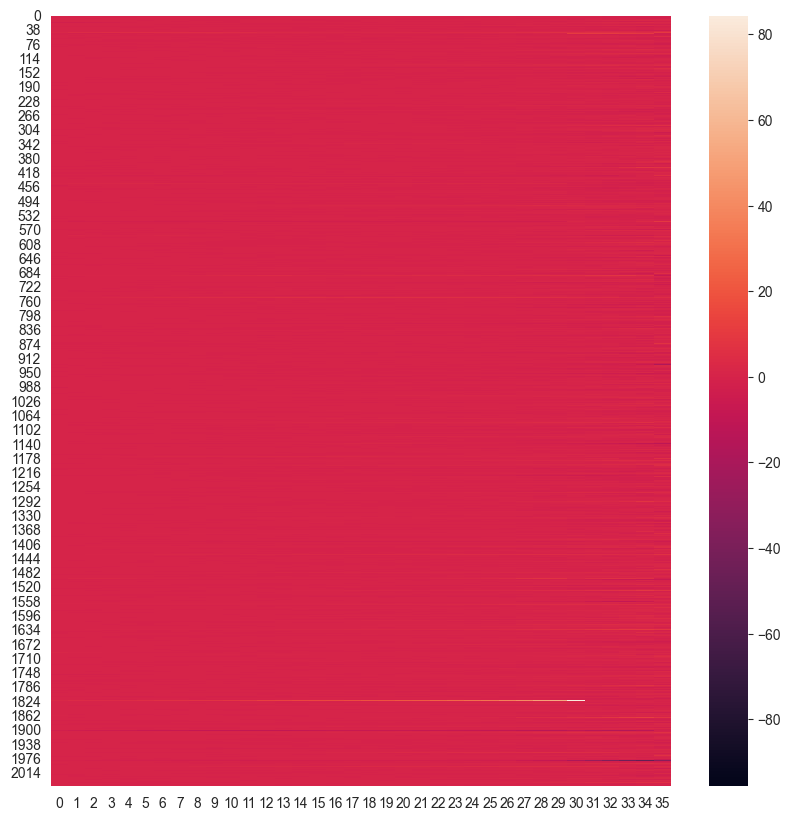

In [33]:
# WRITE PYTHON FOR FIB(16)
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.heatmap(torch.where((activations_tensor > -100) & (activations_tensor < 100), activations_tensor, 0), ax=ax)


<Axes: >

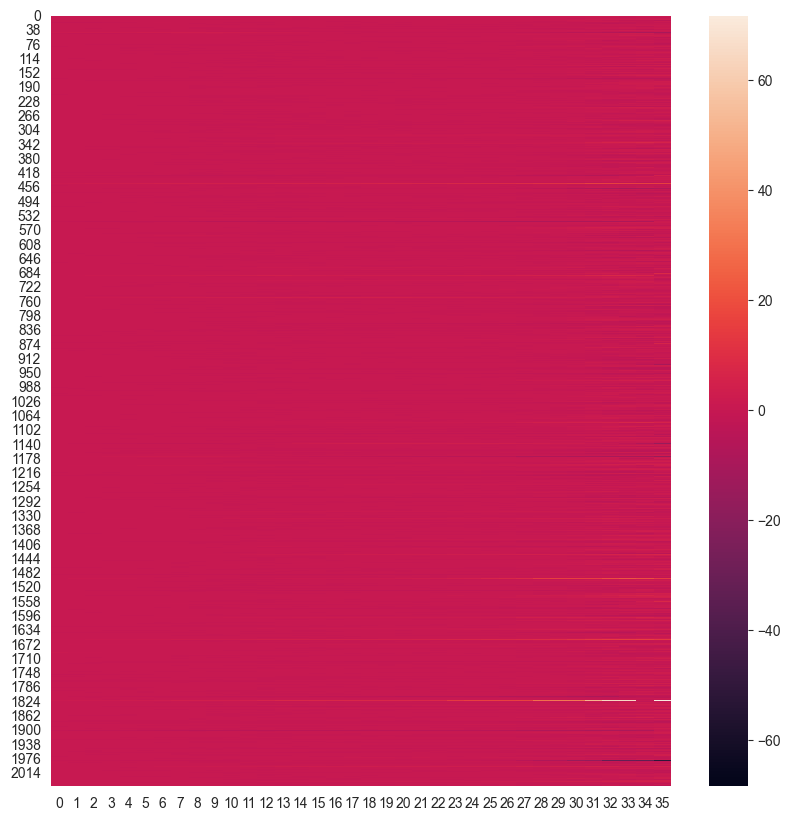

In [20]:
# TALK ABOUT THE START OF WORLD WAR 1
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.heatmap(torch.where((activations_tensor > -100) & (activations_tensor < 100), activations_tensor, 0), ax=ax)